In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import random
import os
import zipfile
from PIL import Image
import io as BytesIO
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

**DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file = r"/content/drive/My Drive/DATASET - Copy.zip"
path_folder = "path_fold"
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(path_folder)

In [ ]:
train_dir = os.path.join(path_folder, 'TRAIN')
test_dir = os.path.join(path_folder, 'TEST')

In [ ]:
train_dir_O = os.listdir(os.path.join(train_dir, 'O'))
train_dir_R = os.listdir(os.path.join(train_dir, 'R'))
test_dir_O = os.listdir(os.path.join(test_dir, 'O'))
test_dir_R = os.listdir(os.path.join(test_dir, 'R'))

print(f'Total train O images: {len(train_dir_O)}')
print(f'Total train R images: {len(train_dir_R)}')
print(f'Total test O images: {len(test_dir_O)}')
print(f'Total test R images: {len(test_dir_R)}')

Total train O images: 12575
Total train R images: 9999
Total test O images: 1411
Total test R images: 1112


Sample images from class 'O'


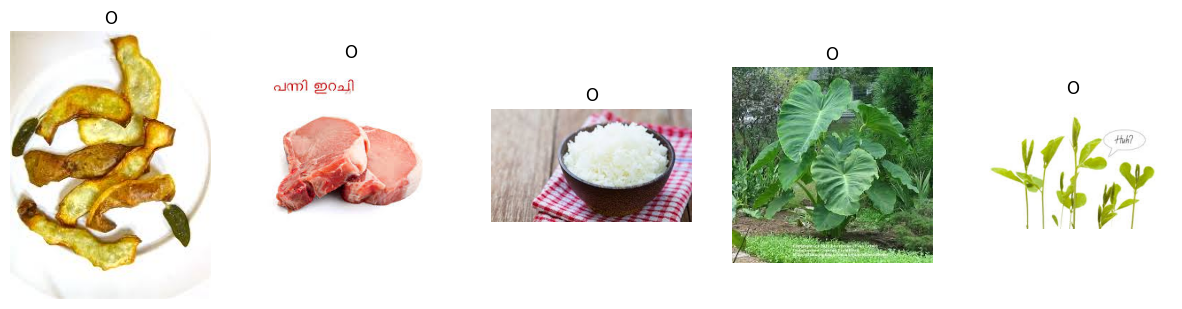

Sample images from class 'R'


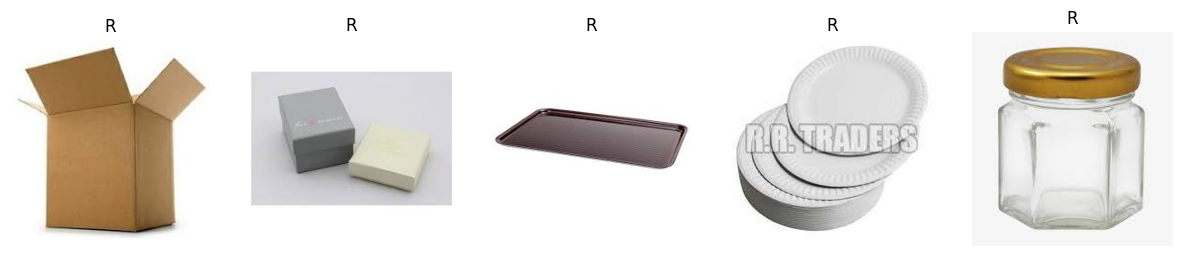

In [ ]:
def visualize_samples(folder_path, class_name, num_samples=5):
    class_folder = os.path.join(folder_path, class_name)
    sample_files = random.sample(os.listdir(class_folder), num_samples)
    plt.figure(figsize=(15, 5))
    for i, file_name in enumerate(sample_files):
        img_path = os.path.join(class_folder, file_name)
        img = Image.open(img_path)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

print("Sample images from class 'O'")
visualize_samples(train_dir, 'O')

print("Sample images from class 'R'")
visualize_samples(train_dir, 'R')

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 22574 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='categorical')

Found 2523 files belonging to 2 classes.


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#model 1
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model():
    model = tf.keras.models.Sequential([
        layers.InputLayer(input_shape=(150, 150, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy'])

    return model

In [ ]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,790,018 (86.94 MB)

 Trainable params: 22,788,098 (86.93 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 87s 65ms/step - accuracy: 0.7796 - loss: 0.8652 - val_accuracy: 0.8878 - val_loss: 0.2827
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 60s 53ms/step - accuracy: 0.8476 - loss: 0.3672 - val_accuracy: 0.8855 - val_loss: 0.3121
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.8617 - loss: 0.3428 - val_accuracy: 0.8938 - val_loss: 0.2769
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.8785 - loss: 0.3037 - val_accuracy: 0.8997 - val_loss: 0.2580
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 59s 52ms/step - accuracy: 0.8925 - loss: 0.2686 - val_accuracy: 0.8565 - val_loss: 0.3222
Epoch 6/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 82s 53ms/step - accuracy: 0.9139 - loss: 0.2211 - val_accuracy: 0.8633 - val_loss: 0.3622
Epoch 7/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 82s 52ms/step - accuracy: 0.9308 - loss: 0.1805 - val_accuracy: 0.8934 - val_loss: 0.2866


In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Tampilkan grafik
plt.tight_layout()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8978 - loss: 0.2648
Validation Loss: 0.28661850094795227
Validation Accuracy: 0.893380880355835
